# Process
In this notebook, I will check whether other properties relate with popularity in the data.

# A. Import Libraries

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from split_users import split
from collections import Counter

# B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [52]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_users = 0.2# the limit for a user to be considered High Preference
top_fraction_items = 0.2
split_popularity_by = "pop_fraq"
split_gender_by = "male_female_difference" 
split_country_by = "ratio_USA"

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [53]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_popularity_by=="pop_fraq") else "_sbpif")
addition_gender = addition_1 + "_tfu"+str(int(100*top_fraction_users))+  "_mfd"
addition_country = addition_1 + "_tfu"+str(int(100*top_fraction_users))+ "_USAr"

In [54]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

# C. Read files

In [55]:
processed_file_location = "data/processed/" # here we store the processed data files

### Gender

In [56]:
low_mp = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_gender+".csv", index_col=0, header=0, low_memory=False).fillna("")
med_mp = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_gender+".csv", index_col=0, header=0, low_memory=False).fillna("")
high_mp = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_gender+".csv", index_col=0, header=0, low_memory=False).fillna("")


### Country

In [57]:
low_Up = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_country+".csv", index_col=0, header=0, low_memory=False).fillna("")
med_Up = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_country+".csv", index_col=0, header=0, low_memory=False).fillna("")
high_Up = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_country+".csv", index_col=0, header=0, low_memory=False).fillna("")


### Popularity

In [58]:
df_item_dist= pd.read_csv(processed_file_location +recommendation_type + "/item_pop_dist"+addition_1+".csv", index_col=0)

In [59]:
low_popularity = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_4+".csv", index_col=0)
med_popularity = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_4+".csv", index_col=0)
high_popularity = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_4+".csv", index_col=0)

### Mapped ratings

In [60]:
mapped_ratings_with_properties = pd.read_csv("https://raw.githubusercontent.com/SavvinaDaniil/BiasInRecommendation/main/data/processed/books/mapped_ratings_with_properties.csv", index_col=0)

In [61]:
gender_dict = {}
country_dict = {}
for isbn in mapped_ratings_with_properties.ISBN.unique():
    gender_dict[isbn] = mapped_ratings_with_properties.gender[mapped_ratings_with_properties.ISBN == isbn].iloc[0]
    country_dict[isbn] = mapped_ratings_with_properties.country[mapped_ratings_with_properties.ISBN == isbn].iloc[0]

# D. Compare properties with 'popular' items

In [62]:
df_item_dist["gender"] = ""
df_item_dist["country"] = ""

for index, row in df_item_dist.iterrows():
    gender = gender_dict[index]
    country = country_dict[index]
    df_item_dist.at[index, "gender"] = gender
    df_item_dist.at[index, "country"] = country

In [63]:
num_pop_items = int(top_fraction_items * len(df_item_dist))


The items that are considered popular:

In [64]:
pop_item_dist = df_item_dist.iloc[:num_pop_items]

### D1. Gender

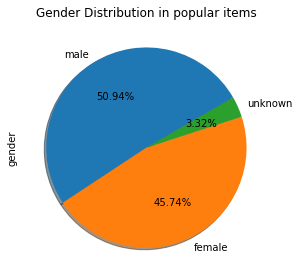

In [65]:
fig, ax = plt.subplots()
pop_item_dist.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular items")
fig.tight_layout()

### D2. Country

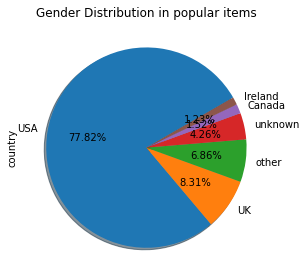

In [66]:
fig, ax = plt.subplots()
pop_item_dist.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular items")
fig.tight_layout()

# E. Compare properties with average popularity

# F. Analyze properties for every popularity user group

In [71]:
full_gender_df = pd.concat([low_mp, med_mp, high_mp])
full_country_df = pd.concat([low_Up, med_Up, high_Up])

In [72]:
low_popularity["male_female_difference"] = ""
low_popularity["ratio_USA"] = ""
med_popularity["male_female_difference"] = ""
med_popularity["ratio_USA"] = ""
high_popularity["male_female_difference"] = ""
high_popularity["ratio_USA"] = ""

In [74]:
for index, row in low_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    low_popularity.at[index, "male_female_difference"] = mfd
    low_popularity.at[index, "ratio_USA"] = rU

In [77]:
for index, row in high_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    high_popularity.at[index, "male_female_difference"] = mfd
    high_popularity.at[index, "ratio_USA"] = rU

Let's see!

In [79]:
low_popularity.male_female_difference.mean(),med_popularity.male_female_difference.mean(),high_popularity.male_female_difference.mean()

(0.029160211348427428, 0.06981698040184661, 0.04293495015522866)

In [80]:
low_popularity.ratio_USA.mean(),med_popularity.ratio_USA.mean(),high_popularity.ratio_USA.mean()

(0.673242689815528, 0.7256530296476071, 0.7839245433556618)